# **Regression by AutoGluon**

Google Colaboratory環境でのDiamondsデータセットの回帰実行サンプル

学習のプリセット値によって結果がどう変わるか確認する  

<br>
【公式】AutoGluon: AutoML for Text, Image, and Tabular Data  
https://auto.gluon.ai/stable/index.html

Predicting Columns in a Table - Quick Start  
https://auto.gluon.ai/stable/tutorials/tabular_prediction/tabular-quickstart.html

【reference】AutoGluon Predictors  
https://auto.gluon.ai/stable/api/autogluon.predictor.html#autogluon.tabular.TabularPredictor.fit

【機械学習】AutoGluonの使い方・クイックスタートの解説(表形式データ) -  2021-06-17  
https://predora005.hatenablog.com/entry/2021/06/17/000000

## **Google Colaboratoyの環境確認/設定**

In [1]:
# Linuxの環境確認
!cat /etc/issue   # OSバージョン
!uname -a         # 〃
!cat /proc/cpuinfo | grep 'model name'                                   # CPU
!cat /proc/meminfo | grep Mem | awk '{print $1 " " $2/1024/1024 " GB"}'  # メモリ
!df -h | grep -v -e tmp -e shm                                           # ファイルシステム
!cat /proc/uptime  | awk '{print $1/60/60 " hours (" $1 "sec)"}'         # uptime
!nvidia-smi                                                              # GPU

# AutoGluon
!pip install -U "folium==0.2.1"
!pip install -U "imgaug<0.2.7,>=0.2.5"
!pip install -U "mxnet_cu101<2.0.0"   # for GPU: CUDA 10.1 for goolge colaboratory
!pip install autogluon

Ubuntu 18.04.5 LTS \n \l

Linux 54d2f5bf0771 5.4.104+ #1 SMP Sat Jun 5 09:50:34 PDT 2021 x86_64 x86_64 x86_64 GNU/Linux
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
MemTotal: 25.4597 GB
MemFree: 22.6011 GB
MemAvailable: 24.5477 GB
Filesystem      Size  Used Avail Use% Mounted on
overlay         148G   38G  110G  26% /
/dev/sda1       154G   41G  114G  27% /opt/bin/.nvidia
0.297086 hours (1069.51sec)
Thu Sep  2 08:28:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               | 

## **ライブラリの読み込み**

In [2]:
import sys
print(sys.version)   # pythonバージョン: 3.7.11 (default, Jul  3 2021, 18:01:19) 
import math
import random
import copy
import os
import statistics as stat
from pprint   import pprint
from datetime import datetime, timedelta, timezone
JST = timezone(timedelta(hours=+9), 'JST')
print(f'now: {datetime.now(JST):"%F %T)}') 

import numpy  as np
import pandas as pd
# pandas表示設定値の変更
pd.set_option('display.width',      100)
pd.set_option('display.precision',    4)
pd.set_option('display.max_rows',    20)
pd.set_option('display.max_columns', 12)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew #for some statistics

import sklearn 
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
# metrics for Classificaqtion
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# metrics for  regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#===============================================
import autogluon as ag
from autogluon.tabular import TabularPredictor
#===============================================

import xgboost
import lightgbm
import catboost

#バージョン確認
print(sys.version)
print(f'Module\'s Version; ',
      f'\n sklearn: {sklearn.__version__}, numpy: {np.__version__}, pandas: {pd.__version__},',
      f'\n xgboost: {xgboost.__version__}, lightgbm: {lightgbm.__version__}, catboost: {catboost.__version__},',
      )

3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
now: "2021-09-02 17:29:58)
3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
Module's Version;  
 sklearn: 0.24.2, numpy: 1.19.5, pandas: 1.1.5, 
 xgboost: 1.4.2, lightgbm: 3.2.1, catboost: 0.25.1,


### **関数定義**

In [3]:
### Functions =================================================================
def xdescribe(df, dsp=True, ret=False):   # pandas.describeメソッドの拡張 

    print(f'## Shape:{df.shape}')
    dtype    = pd.DataFrame({'dtype' : df.dtypes        })
    n_na     = pd.DataFrame({'NAs'   : df.isnull().sum()})
    n_unique = pd.DataFrame({'n_unique': [len(df[c].unique()) for c in df.columns]},
                            index=df.columns)
    df_descr = df.describe(include='all').T
    if 'unique' in df_descr.columns:
        df_descr = df_descr.drop(['unique'], axis=1)
    df_descr = pd.concat([dtype, n_na, n_unique, df_descr], axis=1)
    df_descr['count'] = df_descr['count'].astype(int)

    if dsp:
        # backup & restore sttting
        mr = pd.get_option('display.max_rows')  # backup sttting
        pd.set_option('display.max_rows', None) # unlimitted
        display(df_descr)
        pd.set_option('display.max_rows', mr)   # restore sttting

        prt = True
        for idx in df_descr.index:
            if df_descr['dtype'].astype(str)[idx] == 'category':
                if prt:
                    print(f'### Featur: Categories')
                    prt = False 
                print(f' {idx}: \t{df[idx].cat.categories}')

    if ret:
        return df_descr
    else:
        return

### Functions =================================================================
# 変数の分布を確認
def target_dist(df, target_colname):
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df[target_colname])
    skewness    = skew(df[target_colname].dropna())
    print( f'\n 平均 = {mu:.2f}, 分散 = {sigma:.2f}, 歪度 = {skewness:.2f}')

    # plot the distribution
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title(target_colname+' distribution')
    sns.distplot(df[target_colname], fit=norm)

    ax = fig.add_subplot(1, 2, 2)
    stats.probplot(df[target_colname], plot=plt) #Q-Q plot
    plt.show()

## **データの取得・確認**

#### **scikit-learnに含まれているbostonデータセットを使用**

各変数の属性の確認  
目的変数の分布を確認


## Shape:(506, 14)


,dtype,NAs,n_unique,count,mean,std,min,25%,50%,75%,max
CRIM,float64,0,504,506,3.6135,8.6015,0.0063,0.0820,0.2565,3.6771,88.9762
ZN,float64,0,26,506,11.3636,23.3225,0.0000,0.0000,0.0000,12.5000,100.0000
INDUS,float64,0,76,506,11.1368,6.8604,0.4600,5.1900,9.6900,18.1000,27.7400
CHAS,float64,0,2,506,0.0692,0.2540,0.0000,0.0000,0.0000,0.0000,1.0000
NOX,float64,0,81,506,0.5547,0.1159,0.3850,0.4490,0.5380,0.6240,0.8710
RM,float64,0,446,506,6.2846,0.7026,3.5610,5.8855,6.2085,6.6235,8.7800
AGE,float64,0,356,506,68.5749,28.1489,2.9000,45.0250,77.5000,94.0750,100.0000
DIS,float64,0,412,506,3.7950,2.1057,1.1296,2.1002,3.2074,5.1884,12.1265
RAD,float64,0,9,506,9.5494,8.7073,1.0000,4.0000,5.0000,24.0000,24.0000
TAX,float64,0,66,506,408.2372,168.5371,187.0000,279.0000,330.0000,666.0000,711.0000


Shapes: train:(404, 14), valid:(102, 14)

## 目的変数の分布を確認

 平均 = 22.61, 分散 = 9.23, 歪度 = 1.02


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


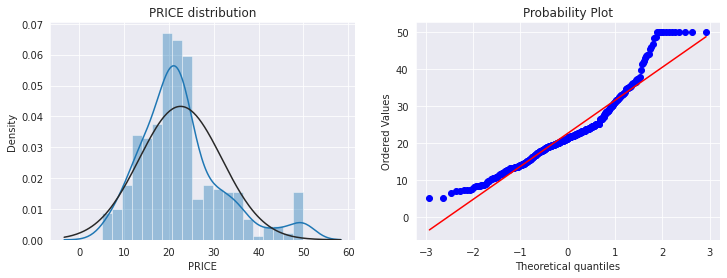

In [37]:
#ボストン住宅価格データセットの読み込み
from sklearn.datasets import load_boston
boston = load_boston()
# データフレームの作成
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['PRICE'] = np.array(boston.target)
xdescribe(df)

target_colname = 'PRICE'          # 目的変数を指定

# データセットの分割 (学習用と学習後の検証用)
df_train, df_valid = train_test_split(df, train_size=0.8, random_state=0, shuffle=True)
print(f'Shapes: train:{df_train.shape}, valid:{df_valid.shape}')

print(f'\n## 目的変数の分布を確認') 
target_dist(df_train, target_colname)

## **学習**

### **学習の準備**

In [152]:
import autogluon as ag
from autogluon.tabular import TabularPredictor

label      = target_colname  # 目的関数 ('price')
save_path  = 'agModels'      # 学習モデルの保管場所
metric     = 'r2'            # specify your evaluation metric here

lst_best_models = []         # 各学習の結果比較用

### **学習1, ほぼデフォルト**

In [153]:
time_start = datetime.now(JST)
print(f'## {time_start:%F %T}')

predictor = TabularPredictor(label=label, eval_metric=metric, path=save_path).fit(df_train)

elapse = (datetime.now(JST)-time_start).total_seconds()
print(f'## {datetime.now(JST):%F %T}, Elapse(Min):{elapse/60:.3f}')

Beginning AutoGluon training ...
AutoGluon will save models to "agModels/"
AutoGluon Version:  0.3.1
Train Data Rows:    404
Train Data Columns: 13
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (50.0, 5.0, 22.61188, 9.23878)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    24018.68 MB
	Train Data (Original)  Memory Usage: 0.04 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1

## 2021-09-02 23:12:30


	0.6315	 = Validation score   (r2)
	0.01s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: KNeighborsDist ...
	0.6914	 = Validation score   (r2)
	0.01s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: LightGBMXT ...


[1000]	train_set's l2: 1.58374	train_set's r2: 0.9803	valid_set's l2: 7.55872	valid_set's r2: 0.907815


	0.9149	 = Validation score   (r2)
	1.82s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.889	 = Validation score   (r2)
	0.78s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestMSE ...
	0.8707	 = Validation score   (r2)
	0.61s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: CatBoost ...
	0.9009	 = Validation score   (r2)
	1.18s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	0.8933	 = Validation score   (r2)
	0.52s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	0.8669	 = Validation score   (r2)
	0.58s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	0.8803	 = Validation score   (r2)
	0.91s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: NeuralNetMXNet ...
	0.8849	 = Validation score   (r2)
	4.62s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: LightGBMLarge ...
	0.8808	 

## 2021-09-02 23:12:44, Elapse(Min):0.229


#### **学習の評価**

In [154]:
#predictor = TabularPredictor.load(save_path) # 保存したモデルを読み込む場合
dic_results = predictor.fit_summary()

# 上位3モデルの結果を保存
n_top = 3
df_description = pd.DataFrame({'learn_description':['learn1_medium']*n_top})
df_leaderboard = dic_results['leaderboard'][0:n_top]
df_hyperparam  = pd.DataFrame({'model_hyperparams':
                               [dic_results['model_hyperparams'][m] for m in df_leaderboard['model']]})
lst_best_models.append(pd.concat([df_description, df_leaderboard, df_hyperparam], axis=1))

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2     0.9180         0.3796    7.9398                  0.0005             0.2960            2       True         12
1            LightGBMXT     0.9149         0.0059    1.8188                  0.0059             1.8188            1       True          3
2              CatBoost     0.9009         0.0017    1.1792                  0.0017             1.1792            1       True          6
3         ExtraTreesMSE     0.8933         0.1025    0.5153                  0.1025             0.5153            1       True          7
4              LightGBM     0.8890         0.0034    0.7820                  0.0034             0.7820            1       True          4
5        NeuralNetMXNet     0.8849         0.1630    4.6182                  0.1630             4.6182        

In [155]:
y_pred = predictor.predict(df_valid.drop(columns=[label]))
perf = predictor.evaluate_predictions(y_true=df_valid[label], y_pred=y_pred, auxiliary_metrics=True)

Evaluation: r2 on test data: 0.7343306355089199
Evaluations on test data:
{
    "r2": 0.7343306355089199,
    "root_mean_squared_error": -4.651133373391418,
    "mean_squared_error": -21.63304165707542,
    "mean_absolute_error": -2.8634925038206815,
    "pearsonr": 0.8628285722386255,
    "median_absolute_error": -1.6739938735961912
}


### **学習2**

good_quality_faster_inference_only_refit =   
{'auto_stack'：True, 'refit_full'：True, 'set_best_to_refit_full'：True, '_ save_bag_folds'：False, 'hyperparameters'： 'light'}

In [156]:
#time_limit = 2*3600          # Sec 処理制限時間
presets    = 'good_quality_faster_inference_only_refit'  # or 'high_quality_fast_inference_only_refit' 


time_start = datetime.now(JST)
print(f'## {time_start:%F %T}')

predictor = TabularPredictor(label=label, eval_metric=metric, path=save_path) \
                        .fit(df_train, presets=presets)

elapse = (datetime.now(JST)-time_start).total_seconds()
print(f'## {datetime.now(JST):%F %T}, Elapse(Min):{elapse/60:.3f}')

Presets specified: ['good_quality_faster_inference_only_refit']
Beginning AutoGluon training ...
AutoGluon will save models to "agModels/"
AutoGluon Version:  0.3.1
Train Data Rows:    404
Train Data Columns: 13
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (50.0, 5.0, 22.61188, 9.23878)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    24019.82 MB
	Train Data (Original)  Memory Usage: 0.04 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Gener

## 2021-09-02 23:12:44


	0.899	 = Validation score   (r2)
	4.14s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ...
	0.8944	 = Validation score   (r2)
	3.72s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ...
	0.8798	 = Validation score   (r2)
	0.61s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	0.9142	 = Validation score   (r2)
	13.17s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ...
	0.9086	 = Validation score   (r2)
	0.51s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	0.8194	 = Validation score   (r2)
	2.88s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: XGBoost_BAG_L1 ...
	0.9073	 = Validation score   (r2)
	3.45s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: NeuralNetMXNet_BAG_L1 ...
	0.8671	 = Validation score   (r2)
	15.82s	 = Training   runtime
	0.8s	 = Valida

## 2021-09-02 23:13:43, Elapse(Min):0.974


In [157]:
dic_results = predictor.fit_summary()

n_top = 3
df_description = pd.DataFrame({'learn_description':['learn2_good']*n_top})
df_leaderboard = dic_results['leaderboard'][0:n_top]
df_hyperparam  = pd.DataFrame({'model_hyperparams':
                               [dic_results['model_hyperparams'][m] for m in df_leaderboard['model']]})
lst_best_models.append(pd.concat([df_description, df_leaderboard, df_hyperparam], axis=1))

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L2     0.9190         0.1555   25.2517                  0.0004             0.2569            2      False         10
1               CatBoost_BAG_L1     0.9142         0.0139   13.1697                  0.0139            13.1697            1      False          4
2     ExtraTreesMSE_BAG_L1_FULL     0.9086         0.0838    0.5111                  0.0838             0.5111            1       True         15
3          ExtraTreesMSE_BAG_L1     0.9086         0.0839    0.5091                  0.0839             0.5091            1      False          5
4                XGBoost_BAG_L1     0.9073         0.0179    3.4540                  0.0179             3.4540            1      False          7
5             LightGBMXT_BAG_L1     0.8990         0.0227    4

In [158]:
y_pred = predictor.predict(df_valid.drop(columns=[label]))
perf = predictor.evaluate_predictions(y_true=df_valid[label], y_pred=y_pred, auxiliary_metrics=True)

Evaluation: r2 on test data: 0.7277522386675509
Evaluations on test data:
{
    "r2": 0.7277522386675509,
    "root_mean_squared_error": -4.708365984436408,
    "mean_squared_error": -22.168710243397825,
    "mean_absolute_error": -2.701128415500416,
    "pearsonr": 0.8566765331776403,
    "median_absolute_error": -1.6210222244262695
}


### **学習3**

high_quality_fast_inference_only_refit =  
{'auto_stack'：True, 'refit_full'：True, 'set_best_to_refit_full'：True, '_ save_bag_folds'：False}

In [159]:
#time_limit = 5*3600          # Sec 処理制限時間
presets    = 'high_quality_fast_inference_only_refit'  # 


time_start = datetime.now(JST)
print(f'## {time_start:%F %T}')

predictor = TabularPredictor(label=label, eval_metric=metric, path=save_path) \
                        .fit(df_train, presets=presets)

elapse = (datetime.now(JST)-time_start).total_seconds()
print(f'## {datetime.now(JST):%F %T}, Elapse(Min):{elapse/60:.3f}')

Presets specified: ['high_quality_fast_inference_only_refit']
Beginning AutoGluon training ...
AutoGluon will save models to "agModels/"
AutoGluon Version:  0.3.1
Train Data Rows:    404
Train Data Columns: 13
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (50.0, 5.0, 22.61188, 9.23878)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    24017.36 MB
	Train Data (Original)  Memory Usage: 0.04 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generat

## 2021-09-02 23:13:43


	0.5621	 = Validation score   (r2)
	0.0s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: KNeighborsDist_BAG_L1 ...
	0.5988	 = Validation score   (r2)
	0.01s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L1 ...
	0.899	 = Validation score   (r2)
	4.16s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ...
	0.8944	 = Validation score   (r2)
	3.88s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ...
	0.878	 = Validation score   (r2)
	0.61s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	0.9142	 = Validation score   (r2)
	13.22s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ...
	0.9091	 = Validation score   (r2)
	0.52s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	0.828	 = Validation score   (r2)
	2.89s	 = Training   runtime
	0.07s	 = Validati

## 2021-09-02 23:14:45, Elapse(Min):1.035


In [160]:
dic_results = predictor.fit_summary()

n_top = 3
df_description = pd.DataFrame({'learn_description':['learn3_high']*n_top})
df_leaderboard = dic_results['leaderboard'][0:n_top]
df_hyperparam  = pd.DataFrame({'model_hyperparams':
                               [dic_results['model_hyperparams'][m] for m in df_leaderboard['model']]})
lst_best_models.append(pd.concat([df_description, df_leaderboard, df_hyperparam], axis=1))

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L2     0.9199         0.9342   44.5431                  0.0006             0.3085            2      False         12
1               CatBoost_BAG_L1     0.9142         0.0136   13.2249                  0.0136            13.2249            1      False          6
2          ExtraTreesMSE_BAG_L1     0.9091         0.0847    0.5161                  0.0847             0.5161            1      False          7
3     ExtraTreesMSE_BAG_L1_FULL     0.9091         0.0852    0.5093                  0.0852             0.5093            1       True         19
4                XGBoost_BAG_L1     0.9073         0.0177    3.3198                  0.0177             3.3198            1      False          9
5             LightGBMXT_BAG_L1     0.8990         0.0176    4

In [161]:
y_pred = predictor.predict(df_valid.drop(columns=[label]))
perf = predictor.evaluate_predictions(y_true=df_valid[label], y_pred=y_pred, auxiliary_metrics=True)

Evaluation: r2 on test data: 0.7036771117053021
Evaluations on test data:
{
    "r2": 0.7036771117053021,
    "root_mean_squared_error": -4.9121390709293635,
    "mean_squared_error": -24.12911025215079,
    "mean_absolute_error": -2.8579761907166126,
    "pearsonr": 0.8486171771345293,
    "median_absolute_error": -1.7739340782165538
}


### **学習4**

best_quality = {'auto_stack'：True}


In [162]:
#time_limit = 8*3600         # Sec 処理制限時間
presets    = 'best_quality'  # 


time_start = datetime.now(JST)
print(f'## {time_start:%F %T}')

predictor = TabularPredictor(label=label, eval_metric=metric, path=save_path) \
                        .fit(df_train, presets=presets)

elapse = (datetime.now(JST)-time_start).total_seconds()
print(f'## {datetime.now(JST):%F %T}, Elapse(Min):{elapse/60:.3f}')

Presets specified: ['best_quality']
Beginning AutoGluon training ...
AutoGluon will save models to "agModels/"
AutoGluon Version:  0.3.1
Train Data Rows:    404
Train Data Columns: 13
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (50.0, 5.0, 22.61188, 9.23878)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    24016.38 MB
	Train Data (Original)  Memory Usage: 0.04 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatu

## 2021-09-02 23:14:46


	0.5621	 = Validation score   (r2)
	0.01s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: KNeighborsDist_BAG_L1 ...
	0.5988	 = Validation score   (r2)
	0.0s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L1 ...
	0.899	 = Validation score   (r2)
	4.16s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ...
	0.8944	 = Validation score   (r2)
	3.78s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ...
	0.878	 = Validation score   (r2)
	0.62s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	0.9142	 = Validation score   (r2)
	13.48s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ...
	0.9091	 = Validation score   (r2)
	0.52s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	0.8179	 = Validation score   (r2)
	2.85s	 = Training   runtime
	0.07s	 = Validat

## 2021-09-02 23:15:39, Elapse(Min):0.887


In [163]:
dic_results = predictor.fit_summary()

n_top = 3
df_description = pd.DataFrame({'learn_description':['learn4_best']*n_top})
df_leaderboard = dic_results['leaderboard'][0:n_top]
df_hyperparam  = pd.DataFrame({'model_hyperparams':
                               [dic_results['model_hyperparams'][m] for m in df_leaderboard['model']]})
lst_best_models.append(pd.concat([df_description, df_leaderboard, df_hyperparam], axis=1))

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L2     0.9191         0.1497   25.6163                  0.0004             0.3066            2       True         12
1          CatBoost_BAG_L1     0.9142         0.0139   13.4798                  0.0139            13.4798            1       True          6
2     ExtraTreesMSE_BAG_L1     0.9091         0.0832    0.5182                  0.0832             0.5182            1       True          7
3           XGBoost_BAG_L1     0.9073         0.0178    3.3671                  0.0178             3.3671            1       True          9
4        LightGBMXT_BAG_L1     0.8990         0.0173    4.1639                  0.0173             4.1639            1       True          3
5          LightGBM_BAG_L1     0.8944         0.0170    3.7806                  0.0170      

In [164]:
y_pred = predictor.predict(df_valid.drop(columns=[label]))
perf = predictor.evaluate_predictions(y_true=df_valid[label], y_pred=y_pred, auxiliary_metrics=True)

Evaluation: r2 on test data: 0.7095262071256823
Evaluations on test data:
{
    "r2": 0.7095262071256823,
    "root_mean_squared_error": -4.863417270001119,
    "mean_squared_error": -23.652827542145136,
    "mean_absolute_error": -2.7669746539172,
    "pearsonr": 0.8460951910813083,
    "median_absolute_error": -1.7049634933471678
}


### **学習5**
アンサンブルのパラメータを明示的に指定  
num_bag_folds=10, num_bag_sets=3, num_stack_levels=3


In [165]:
#time_limit = 8*3600         # Sec 処理制限時間

time_start = datetime.now(JST)
print(f'## {time_start:%F %T}')

predictor.persist_models()
predictor = TabularPredictor(label=label, eval_metric=metric)\
                        .fit(df_train,
                             num_bag_folds=10, num_bag_sets=3, num_stack_levels=3)
predictor.unpersist_models()

elapse = (datetime.now(JST)-time_start).total_seconds()
print(f'## {datetime.now(JST):%F %T}, Elapse(Min):{elapse/60:.3f}')

## 2021-09-02 23:15:39


Persisting 6 models in memory. Models will require 0.13% of memory.
No path specified. Models will be saved in: "AutogluonModels/ag-20210902_141544/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20210902_141544/"
AutoGluon Version:  0.3.1
Train Data Rows:    404
Train Data Columns: 13
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (50.0, 5.0, 22.61188, 9.23878)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    24018.74 MB
	Train Data (Original)  Memory Usage: 0.04 MB (0.0% of available memory)
	Inferring data type of each feature ba

[1000]	train_set's l2: 1.45458	train_set's r2: 0.981136	valid_set's l2: 14.0575	valid_set's r2: 0.88103
[1000]	train_set's l2: 1.32844	train_set's r2: 0.982619	valid_set's l2: 11.3237	valid_set's r2: 0.896129
[1000]	train_set's l2: 1.32811	train_set's r2: 0.983462	valid_set's l2: 10.7986	valid_set's r2: 0.82983
[1000]	train_set's l2: 1.54734	train_set's r2: 0.979888	valid_set's l2: 6.35553	valid_set's r2: 0.935829
[1000]	train_set's l2: 1.45397	train_set's r2: 0.978532	valid_set's l2: 15.2419	valid_set's r2: 0.912629
[2000]	train_set's l2: 0.552793	train_set's r2: 0.99126	valid_set's l2: 13.4022	valid_set's r2: 0.925253
[1000]	train_set's l2: 1.36362	train_set's r2: 0.983633	valid_set's l2: 7.90407	valid_set's r2: 0.786768


	0.9124	 = Validation score   (r2)
	25.82s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ...


[1000]	train_set's l2: 0.253875	train_set's r2: 0.995731	valid_set's l2: 8.7555	valid_set's r2: 0.919796
[2000]	train_set's l2: 0.0253806	train_set's r2: 0.99859	valid_set's l2: 6.6042	valid_set's r2: 0.93703
[1000]	train_set's l2: 0.106374	train_set's r2: 0.99777	valid_set's l2: 8.02231	valid_set's r2: 0.8763


	0.9051	 = Validation score   (r2)
	22.82s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ...
	0.878	 = Validation score   (r2)
	0.63s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	0.9223	 = Validation score   (r2)
	33.38s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ...
	0.9091	 = Validation score   (r2)
	0.51s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	0.8503	 = Validation score   (r2)
	17.74s	 = Training   runtime
	0.44s	 = Validation runtime
Fitting model: XGBoost_BAG_L1 ...
	0.9147	 = Validation score   (r2)
	18.75s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: NeuralNetMXNet_BAG_L1 ...
	0.8991	 = Validation score   (r2)
	102.07s	 = Training   runtime
	4.79s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ...
	0.8932	 = Validation score   (r2)
	24.71s	 = Training   runtime
	0.09s

## 2021-09-02 23:31:14, Elapse(Min):15.574


In [166]:
dic_results = predictor.fit_summary()

n_top = 3
df_description = pd.DataFrame({'learn_description':['learn5_individual']*n_top})
df_leaderboard = dic_results['leaderboard'][0:n_top]
df_hyperparam  = pd.DataFrame({'model_hyperparams':
                               [dic_results['model_hyperparams'][m] for m in df_leaderboard['model']]})
lst_best_models.append(pd.concat([df_description, df_leaderboard, df_hyperparam], axis=1))

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3     0.9245        11.7180  404.8318                  0.0005             0.2607            3       True         22
1      WeightedEnsemble_L2     0.9242         5.0639  180.3233                  0.0005             0.3071            2       True         12
2          CatBoost_BAG_L1     0.9223         0.0779   33.3772                  0.0779            33.3772            1       True          6
3      WeightedEnsemble_L4     0.9214        17.2800  619.2361                  0.0004             0.2665            4       True         32
4    NeuralNetMXNet_BAG_L2     0.9204        10.8886  337.7221                  4.8328            91.2939            2       True         20
5          CatBoost_BAG_L3     0.9195        12.1789  489.9847                  0.0984      

In [167]:
y_pred = predictor.predict(df_valid.drop(columns=[label]))
perf = predictor.evaluate_predictions(y_true=df_valid[label], y_pred=y_pred, auxiliary_metrics=True)

Evaluation: r2 on test data: 0.8091577665082534
Evaluations on test data:
{
    "r2": 0.8091577665082534,
    "root_mean_squared_error": -3.9420787892074705,
    "mean_squared_error": -15.539985180319436,
    "mean_absolute_error": -2.400970866633396,
    "pearsonr": 0.9043119995326159,
    "median_absolute_error": -1.396648025512695
}


## **結果比較**

【考察】  
prisetsの値により、利用するモデルの対象が変更される。
同じモデルであれば、prisetsの値によらずstack_level、hyperparamsは同じ値で、性能も同等。よって、複数のprestsで学習することは無意味。時間の許す範囲でBestに近いpreset値を利用するのがよい。ただし、パラメータを明示的に指定すると、同じパラメータでもなぜか結果が良い。


In [168]:
print(f'metric: {metric}')

df_best_models = pd.concat(lst_best_models, axis=0).reset_index(drop=True)
display(df_best_models.sort_values('score_val', ascending=False))


metric: r2


,learn_description,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order,model_hyperparams
12,learn5_individual,WeightedEnsemble_L3,0.9245,11.7180,404.8318,0.0005,0.2607,3,True,22,"{'use_orig_features': False, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': True}"
13,learn5_individual,WeightedEnsemble_L2,0.9242,5.0639,180.3233,0.0005,0.3071,2,True,12,"{'use_orig_features': False, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': True}"
14,learn5_individual,CatBoost_BAG_L1,0.9223,0.0779,33.3772,0.0779,33.3772,1,True,6,"{'use_orig_features': True, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': True}"
6,learn3_high,WeightedEnsemble_L2,0.9199,0.9342,44.5431,0.0006,0.3085,2,False,12,"{'use_orig_features': False, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': False}"
9,learn4_best,WeightedEnsemble_L2,0.9191,0.1497,25.6163,0.0004,0.3066,2,True,12,"{'use_orig_features': False, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': True}"
3,learn2_good,WeightedEnsemble_L2,0.9190,0.1555,25.2517,0.0004,0.2569,2,False,10,"{'use_orig_features': False, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': False}"
0,learn1_medium,WeightedEnsemble_L2,0.9180,0.3796,7.9398,0.0005,0.2960,2,True,12,"{'use_orig_features': False, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': True}"
1,learn1_medium,LightGBMXT,0.9149,0.0059,1.8188,0.0059,1.8188,1,True,3,"{'num_boost_round': 10000, 'num_threads': -1, 'learning_rate': 0.05, 'objective': 'regression', 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True, 'extra_trees': True}"
4,learn2_good,CatBoost_BAG_L1,0.9142,0.0139,13.1697,0.0139,13.1697,1,False,4,"{'use_orig_features': True, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': False}"
7,learn3_high,CatBoost_BAG_L1,0.9142,0.0136,13.2249,0.0136,13.2249,1,False,6,"{'use_orig_features': True, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': False}"


### **feature_importance**

In [169]:
predictor.feature_importance(df_valid)

Computing feature importance via permutation shuffling for 13 features using 102 rows with 3 shuffle sets...
	586.56s	= Expected runtime (195.52s per shuffle set)
	68.77s	= Actual runtime (Completed 3 of 3 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
LSTAT,0.4303,0.0550,0.0027,3,0.7455,0.1150
RM,0.3500,0.0229,0.0007,3,0.4811,0.2188
DIS,0.1175,0.0318,0.0117,3,0.2995,-0.0644
RAD,0.0508,0.0243,0.0343,3,0.1901,-0.0885
B,0.0340,0.0168,0.0364,3,0.1306,-0.0625
AGE,0.0324,0.0086,0.0113,3,0.0816,-0.0168
NOX,0.0293,0.0088,0.0143,3,0.0796,-0.0210
CRIM,0.0234,0.0048,0.0067,3,0.0506,-0.0038
PTRATIO,0.0166,0.0025,0.0037,3,0.0308,0.0023
ZN,0.0108,0.0131,0.1450,3,0.0859,-0.0643
